In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings
from sklearn.model_selection import TimeSeriesSplit
import optuna

warnings.filterwarnings('ignore')

c:\Users\yuema\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# データの読み込み
file_path = 'kadai.xlsx'
df = pd.read_excel(file_path)

In [3]:
# 日時データの変換とソート
time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

df = df.sort_values('final_mes_time').reset_index(drop=True)

target = 'OV'

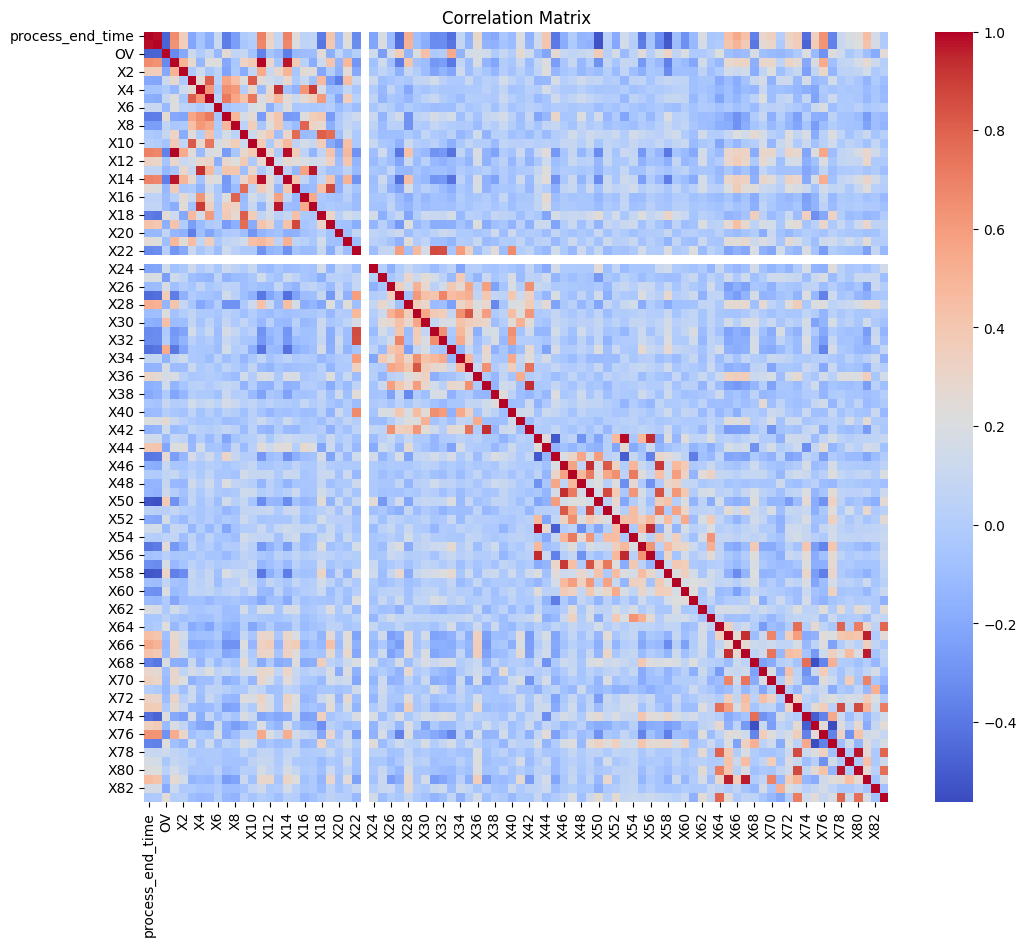

In [4]:
# 相関行列の確認
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
import seaborn as sns
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

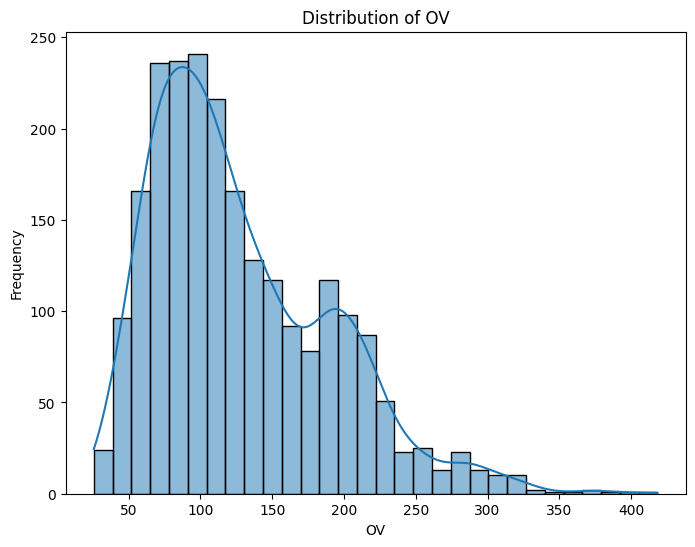

In [5]:
# 目的変数のヒストグラム
plt.figure(figsize=(8, 6))
sns.histplot(df[target], bins=30, kde=True)
plt.title('Distribution of OV')
plt.xlabel('OV')
plt.ylabel('Frequency')
plt.show()

In [6]:
df = df[['X30', 'X83', 'X2', 'X33', 'process_end_time', 'final_mes_time'] + [target]]  # 必要な列だけに絞る

In [7]:
# 特徴量エンジニアリング
df1 = df.copy()
df1['log_OV'] = np.log1p(df1[target])

# 基本情報
# elapsed_hours: プロセス終了から最終メッセージまでの経過時間（時間）
df1['elapsed_hours'] = (df1['final_mes_time'] - df1['process_end_time']).dt.total_seconds() / 3600
# 周期性特徴量の追加（サイン変換）
df1['hour_sin'] = np.sin(2 * np.pi * df1['elapsed_hours'] / 24)
# 周期性特徴量の追加（コサイン変換）
df1['hour_cos'] = np.cos(2 * np.pi * df1['elapsed_hours'] / 24)
# batch_id: プロセス終了時間ごとのバッチID
df1['batch_id'] = df1.groupby('process_end_time').ngroup()
# in_batch_seq: 各プロセス内での連番
df1['in_batch_seq'] = df1.groupby('process_end_time').cumcount() + 1
# is_batch_start: 各プロセスの最初のデータポイントを示すフラグ
df1['is_batch_start'] = (df1['in_batch_seq'] == 1).astype(int)

df = df1.copy()

In [8]:
# 既存変数の選定
X_cols = [c for c in df1.columns if c.startswith('X')]
# 相関の高い特徴量の確認
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
# 上位20個の特徴量
top_X_cols = corrs.head(20).index.tolist()

In [9]:
# バッチごとの特徴量変化量の計算
batch_X_mean = df.groupby('batch_id')[top_X_cols].mean()
batch_X_diff = batch_X_mean.diff().abs().fillna(0)
batch_X_diff.columns = [f'Delta_{c}' for c in batch_X_diff.columns]
batch_X_diff['Total_Recipe_Change'] = batch_X_diff.sum(axis=1)

df = df.merge(batch_X_diff, on='batch_id', how='left')

In [10]:
# 前ロットの統計量
# 前ロットの平均値、最大値、最終値を計算
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
# シフト
batch_stats_prev['batch_id'] += 1
# マージ
df = df.merge(batch_stats_prev, on='batch_id', how='left')

In [11]:
# 類似レシピ検索
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
batch_start_vals = df[df['is_batch_start'] == 1].set_index('batch_id')['log_OV']

nearest_stats = []
nearest_start_direct = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

In [12]:
# 類似バッチの統計量計算
for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        nearest_start_direct.append(batch_start_vals.mean())
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    nearest_idx = np.argmin(dists)
    if nearest_idx in batch_start_vals.index:
        nearest_start_direct.append(batch_start_vals.loc[nearest_idx])
    else:
        nearest_start_direct.append(batch_start_vals.mean())

    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['sim_start_ov_direct'] = nearest_start_direct # 追加
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

In [13]:
# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last', 'sim_start_ov_direct']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

In [14]:
# バッチ開始フラグとの相互作用特徴量
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_start_ov_direct']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

In [15]:
# 時系列特徴量の追加
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

In [16]:
print(len(df))

2276


In [17]:
# パラメータチューニング
print("Preparing Data for Robust Tuning...")
features = [c for c in df.columns if c not in ['OV', 'log_OV', 'process_end_time', 'final_mes_time']]

test_len = 500
df_train_full = df.iloc[:-test_len].copy().reset_index(drop=True)

# Lassoのトレンド計算
features_idx = [c for c in df_train_full.columns if c in features]
X_full = df_train_full[features_idx]
y_full = df_train_full['log_OV']

scaler = StandardScaler()
X_full_sc = scaler.fit_transform(X_full)
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_full_sc, y_full)
trend_full = lasso.predict(X_full_sc)
resid_full = y_full - trend_full

# Optuna 目的関数の定義
def objective_robust(trial):
    params_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0), 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # 補正ロジック
    gain = trial.suggest_float('reflection_gain', 0.1, 0.8)
    #clip = trial.suggest_float('clip_limit', 0.5, 3.0)
    clip = 0.8  # 固定値に変更
    
    # Start行の重み
    start_weight = trial.suggest_float('start_weight', 5.0, 20.0)

    # 時系列クロスバリデーション
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    
    for train_index, val_index in tscv.split(X_full):
        X_tr, X_val = X_full.iloc[train_index], X_full.iloc[val_index]
        y_resid_tr, y_resid_val = resid_full.iloc[train_index], resid_full.iloc[val_index]
        y_val_raw = y_full.iloc[val_index]
        trend_val = trend_full[val_index]
        
        # 重み作成
        weights_tr = np.ones(len(y_resid_tr))
        is_start_tr = df_train_full.iloc[train_index]['is_batch_start'].values
        weights_tr[is_start_tr == 1] = start_weight
        
        # モデル学習
        model = xgb.XGBRegressor(**params_xgb)
        model.fit(X_tr, y_resid_tr, sample_weight=weights_tr)
        
        # 検証 (Validation)
        last_error = 0.0
        fold_preds = []
        val_indices = X_val.index.tolist()
        
        for idx in val_indices:
            row_X = X_full.iloc[[idx]]
            is_start = df_train_full.loc[idx, 'is_batch_start']
            
            # 予測
            pred_resid = model.predict(row_X)[0]
            
            # 補正
            corr = 0.0
            if is_start == 1:
                corr = last_error * gain
                corr = np.clip(corr, -clip, clip)
                pred_resid += corr
            
            # 合体
            final_pred = trend_val[idx - val_indices[0]] + pred_resid
            fold_preds.append(final_pred)
            
            # 誤差更新
            if is_start == 1:
                actual = y_val_raw[idx]
                raw_pred = trend_val[idx - val_indices[0]] + (pred_resid - corr)
                last_error = actual - raw_pred

        rmse = np.sqrt(mean_squared_error(y_val_raw, fold_preds))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Optunaによるパラメータ探索
print("Robust Optuna Starting (Time Series CV)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective_robust, n_trials=50)

# 結果
best_run_results = study.best_params

# 最適モデルのRMSEスコア表示
print(f"Best CV RMSE Score: {study.best_value:.4f}")



Preparing Data for Robust Tuning...


[I 2026-01-19 11:55:52,986] A new study created in memory with name: no-name-9edb2a34-4cb7-449a-a955-c0304c586dd0


Robust Optuna Starting (Time Series CV)...


[I 2026-01-19 11:55:59,233] Trial 0 finished with value: 0.27445739748873244 and parameters: {'n_estimators': 427, 'learning_rate': 0.01860893621967679, 'max_depth': 4, 'subsample': 0.9495154781782094, 'colsample_bytree': 0.6538218478676684, 'reg_alpha': 1.384443664362346, 'reg_lambda': 4.21538873198916, 'reflection_gain': 0.5167778550274823, 'start_weight': 16.43241808895598}. Best is trial 0 with value: 0.27445739748873244.
[I 2026-01-19 11:56:06,254] Trial 1 finished with value: 0.27535074013416333 and parameters: {'n_estimators': 591, 'learning_rate': 0.0234860826829969, 'max_depth': 5, 'subsample': 0.9545448223454416, 'colsample_bytree': 0.9610271163633581, 'reg_alpha': 3.8335996430588217, 'reg_lambda': 0.7931909867392029, 'reflection_gain': 0.6102974793682069, 'start_weight': 15.098373904862248}. Best is trial 0 with value: 0.27445739748873244.
[I 2026-01-19 11:56:12,502] Trial 2 finished with value: 0.27670114483428937 and parameters: {'n_estimators': 381, 'learning_rate': 0.044

Best CV RMSE Score: 0.2687


In [18]:
# 変数に格納
params = ['reflection_gain', 'clip_limit', 'start_weight', 'log_OV', 'process_end_time', 'final_mes_time']
best_params_xgb = {k: v for k, v in best_run_results.items() if k not in params}
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1
best_params_xgb['verbosity'] = 0
reflection_gain = best_run_results['reflection_gain']
#clip_limit = best_run_results['clip_limit']
clip_limit = 0.8
start_weight = best_run_results['start_weight'] # ->6.943082349411925
#start_weight = 20.0
print(best_run_results)

{'n_estimators': 327, 'learning_rate': 0.01684379788979724, 'max_depth': 7, 'subsample': 0.8524085616912146, 'colsample_bytree': 0.6911153812036531, 'reg_alpha': 2.9669611740777615, 'reg_lambda': 1.6433185995836534, 'reflection_gain': 0.3284499296918183, 'start_weight': 15.543635714281443}


In [19]:
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

test_size = 500
start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df.iloc[:start_index][target].max() * 1.5

last_start_error = 0.0

print(f"特徴量数: {len(features)}")
print("予測開始 (Best Mix + Safety-Clipped Reflection)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # 重みづけ
    weights = np.ones(len(y_train_log))
    weights[df.iloc[:i]['is_batch_start'] == 1] = start_weight

    # Lasso回帰
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    
    resid_log = y_train_log - pred_log_lasso

    # 補正用LightGBM
    lgb_train = lgb.Dataset(X_train, resid_log, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, 'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # 補正用XGBoost
    model_xgb = xgb.XGBRegressor(**best_params_xgb)
    model_xgb.fit(X_train, resid_log, sample_weight=weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # アンサンブル学習による補正
    pred_resid = (pred_log_lgb + pred_log_xgb) / 2
    
    if is_start == 1:
        correction = last_start_error * reflection_gain
        correction = np.clip(correction, -clip_limit, clip_limit)
        pred_resid += correction

    # 最終予測値の計算と逆変換
    final_pred_log = pred_log_lasso + pred_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)
    
    # 誤差記録
    if is_start == 1:
        actual_log = df.iloc[i]['log_OV']
        raw_pred_total = pred_log_lasso + ((pred_log_lgb + pred_log_xgb) / 2)
        last_start_error = actual_log - raw_pred_total

特徴量数: 35
予測開始 (Best Mix + Safety-Clipped Reflection)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276


設定...全体RMSE, Batch Start RMSE, Normal Seq RMSE<br>
clip_limit=0.8でその他はパラメータチューニングした時...31.98, 66.75, 29.28<br>
start_weight=20に追加変更...32.28, 65.18, 29.79<br>
バッチごとの特徴量変化量の計算し、start_weightはパラメータチューニング...31.40, 68.43, 28.42<br>
clip_limit=10に変更...31.40, 

--------------------------------------------------
Overall RMSE         : 33.6923
Batch Start RMSE (1st): 56.7315
Normal Seq RMSE (2nd+): 32.1670
--------------------------------------------------


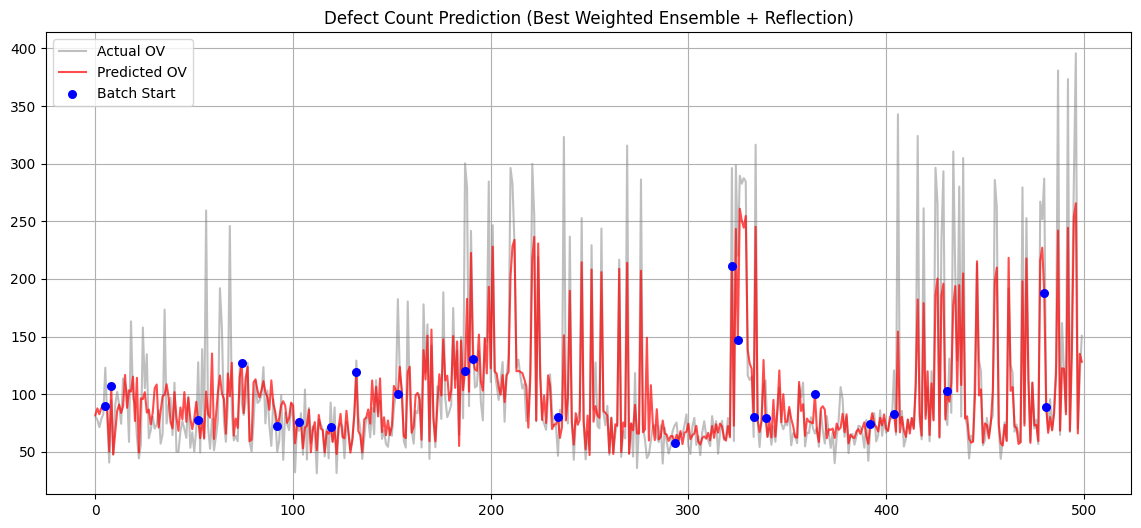

In [20]:
# 評価指標の計算
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)

plt.title("Defect Count Prediction (Best Weighted Ensemble + Reflection)")
plt.legend()
plt.grid(True)
plt.show()

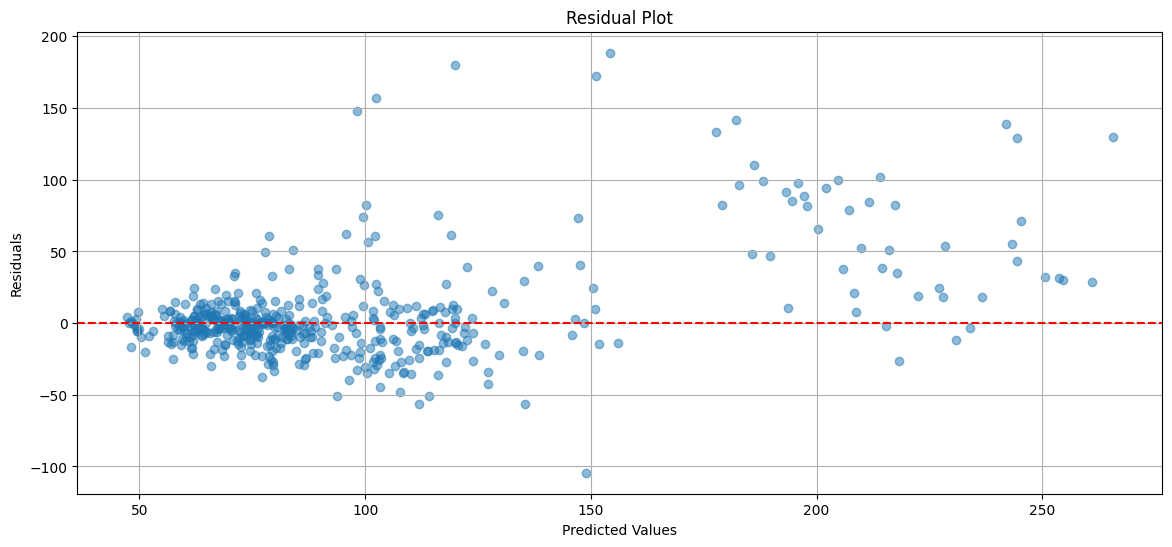

In [21]:
# 残差グラフの描画
residuals = y_true - y_pred
plt.figure(figsize=(14, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

全変数 35 個中、Lassoが使用したのは 23 個です。

=== Lasso Feature Importance (Top 20) ===
                           Feature  Coefficient
                     grouped_lag_1     0.274650
                               X33     0.141810
    Interact_Start_prev_batch_mean     0.122713
                               X30     0.120177
                   prev_batch_mean     0.080037
                    is_batch_start     0.077497
Interact_Start_sim_start_ov_direct     0.058010
                               X83     0.054518
                      global_lag_2     0.037142
                      in_batch_seq    -0.024181
                         Delta_X83    -0.022909
                Interact_Start_X30     0.019592
                      global_lag_1     0.018955
                    sim_batch_last     0.015738
                      global_lag_3     0.013147
                         Delta_X33     0.012206
                     elapsed_hours     0.009612
                     grouped_lag_2     0.009143
              

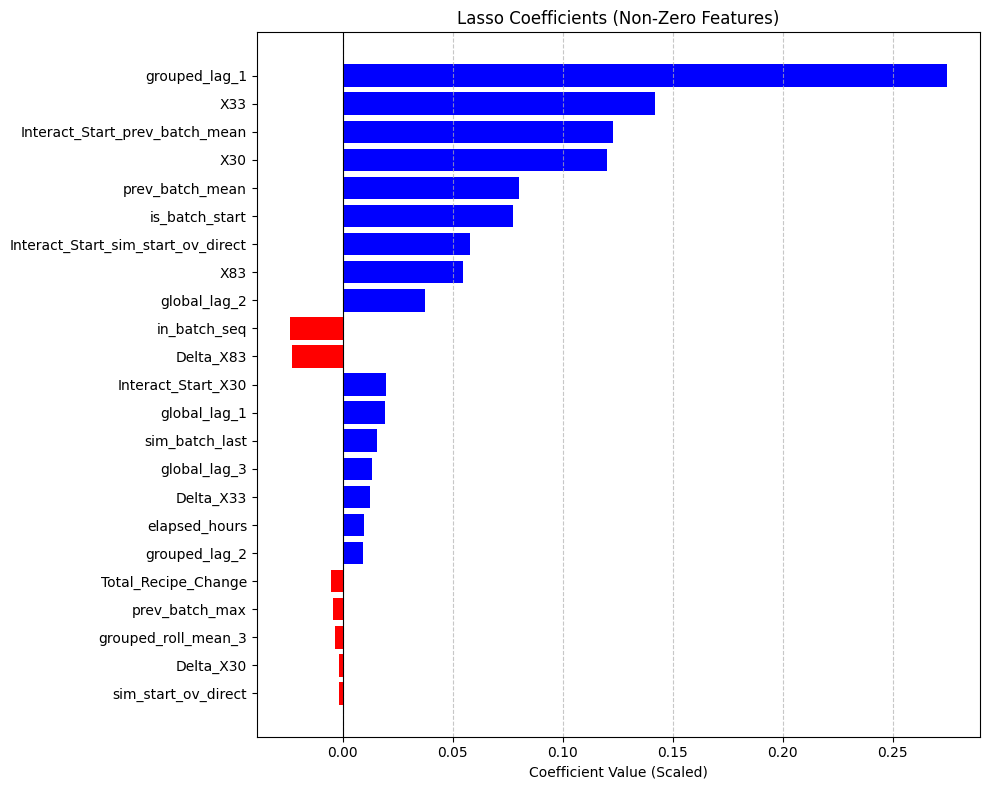

In [22]:
# Lassoの特徴量重要度
lasso_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_,
    'Abs_Coeff': np.abs(lasso.coef_) 
})

lasso_used = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values('Abs_Coeff', ascending=False)

print(f"全変数 {len(features)} 個中、Lassoが使用したのは {len(lasso_used)} 個です。\n")
print("=== Lasso Feature Importance (Top 20) ===")
print(lasso_used[['Feature', 'Coefficient']].head(20).to_string(index=False))

plt.figure(figsize=(10, 8))
top_plot = lasso_used.sort_values('Abs_Coeff', ascending=True)

colors = ['red' if c < 0 else 'blue' for c in top_plot['Coefficient']]
plt.barh(top_plot['Feature'], top_plot['Coefficient'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Lasso Coefficients (Non-Zero Features)")
plt.xlabel("Coefficient Value (Scaled)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()